# PLAN

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from scipy.fftpack import fft
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split as split
from sklearn.preprocessing import StandardScaler

### Loading data

In [2]:
train = pd.read_parquet('../data/train.parquet')
test = pd.read_parquet('../data/test.parquet')
sample_submission = pd.read_csv('../data/sample_submission.csv')

### Show data

In [4]:
train.head()

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0


In [5]:
test.head()

,id,dates,values
0,6125,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.85, -0.04, 0.19, -0.45, -0.75, -0.95, -2.91..."
1,26781,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.41, 0.39, -0.47, -0.9, -1.46, -0.51, 0.51,..."
2,13333,"[2016-06-01, 2016-07-01, 2016-08-01, 2016-09-0...","[-0.29, -1.26, 0.17, -1.22, 0.45, -0.94, 0.16,..."
3,53218,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.47, 1.55, -0.03, 0.57, -0.57, 0.6, 0.27, 1..."
4,84204,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[2.33, 1.39, -1.03, -2.64, 1.89, 1.77, 1.43, 1..."


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      80000 non-null  int64  
 1   dates   80000 non-null  object 
 2   values  80000 non-null  object 
 3   label   80000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.4+ MB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20000 non-null  int64 
 1   dates   20000 non-null  object
 2   values  20000 non-null  object
dtypes: int64(1), object(2)
memory usage: 468.9+ KB


### Distribution of classes

In [8]:
#Checking dataframe's shape
print(f'train shape: {train.shape}')
print(f'test shape: {test.shape}')

train shape: (80000, 4)
test shape: (20000, 3)


In [9]:
unique_values = train['label'].unique()
print(unique_values)

[0. 1.]


<Axes: xlabel='label'>

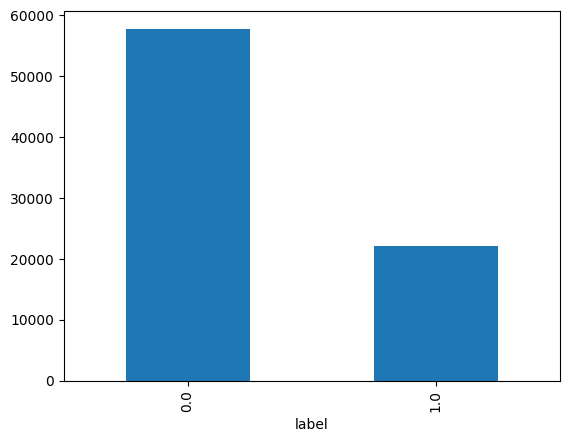

In [10]:
train['label'].value_counts().plot(kind='bar')

In [11]:
class_counts = train['label'].value_counts(normalize=True) * 100
print(class_counts)

label
0.0    72.275
1.0    27.725
Name: proportion, dtype: float64


##### Convert data into dataframe

In [3]:
train_df = pd.DataFrame(train)
df_train_exploded = train_df.explode(['dates', 'values']).reset_index(drop=True)

df_train_exploded

,id,dates,values,label
0,19114,2016-01-01,-1.86,0.0
1,19114,2016-02-01,0.79,0.0
2,19114,2016-03-01,1.4,0.0
3,19114,2016-04-01,0.15,0.0
4,19114,2016-05-01,0.0,0.0
...,...,...,...,...
5155407,98870,2019-11-01,1.40335,1.0
5155408,98870,2019-12-01,0.26335,1.0
5155409,98870,2020-01-01,-1.73665,1.0
5155410,98870,2020-02-01,-0.38665,1.0


In [13]:
df_train_exploded.dtypes

id          int64
dates      object
values     object
label     float64
dtype: object

In [4]:
#convert dates into datetime format
df_train_exploded['values'] = df_train_exploded['values'].astype(float)
df_train_exploded['dates'] = pd.to_datetime(df_train_exploded['dates'])
df_train_exploded.dtypes

id                 int64
dates     datetime64[ns]
values           float64
label            float64
dtype: object

##### Missing values

In [15]:
# it is easier to work with a percentage ratio of missing values
def percentage_ratio(data):
    datatype = pd.DataFrame(data.dtypes,columns=["Data Type"])
    datatype["Missing Values"]=data.isnull().sum()
    datatype["% Missing Values"]=data.isnull().sum()/len(data)*100
    return datatype.sort_values(by="% Missing Values", ascending=False)

In [16]:
percentage_ratio(df_train_exploded)

,Data Type,Missing Values,% Missing Values
values,float64,4582,0.088877
id,int64,0,0.000000
dates,datetime64[ns],0,0.000000
label,float64,0,0.000000


In [5]:
def fillna_gaps(data, group_col, value_col):
    def fill_group(group):
        if group[value_col].isnull().all():
            return group.fillna(0)
        else:
            median_value = group[value_col].median()
            group[value_col] = group[value_col].fillna(median_value)
            return group

    data_filled = data.groupby(group_col).apply(fill_group, include_groups=False).reset_index(drop=True)

    return data_filled

In [6]:
df_train_filled =fillna_gaps(df_train_exploded, 'id', 'values')

In [19]:
percentage_ratio(df_train_exploded)

,Data Type,Missing Values,% Missing Values
values,float64,4582,0.088877
id,int64,0,0.000000
dates,datetime64[ns],0,0.000000
label,float64,0,0.000000


### 1. Statistical Features

In [7]:
def statistical_features(data):
    def safe_skew(x):
        if x.nunique() > 1:  
            return skew(x)
        else:
            return 0  

    def safe_kurtosis(x):
        if x.nunique() > 1:
            return kurtosis(x)
        else:
            return 0

    stats = data.groupby('id')['values'].agg([
        'mean', 
        'std', 
        'min', 
        'max', 
        'median', 
        lambda x: x.quantile(0.25), 
        lambda x: x.quantile(0.75),
        safe_skew,     
        safe_kurtosis  
    ]).reset_index()

   
    stats.columns = [
        'id', 'mean_value', 'std_value', 'min_value', 'max_value', 
        'median_value', 'q1_value', 'q3_value', 'skewness_value', 'kurtosis_value'
    ]

  
    result = pd.merge(data, stats, on='id')

    return result


In [8]:
train_stat = statistical_features(df_train_exploded)

In [22]:
train_stat.head()

,id,dates,values,label,mean_value,std_value,min_value,max_value,median_value,q1_value,q3_value,skewness_value,kurtosis_value
0,19114,2016-01-01,-1.86,0.0,0.02371,1.348189,-4.84,3.49,-0.11,-0.6825,0.77,-0.304166,1.889654
1,19114,2016-02-01,0.79,0.0,0.02371,1.348189,-4.84,3.49,-0.11,-0.6825,0.77,-0.304166,1.889654
2,19114,2016-03-01,1.40,0.0,0.02371,1.348189,-4.84,3.49,-0.11,-0.6825,0.77,-0.304166,1.889654
3,19114,2016-04-01,0.15,0.0,0.02371,1.348189,-4.84,3.49,-0.11,-0.6825,0.77,-0.304166,1.889654
4,19114,2016-05-01,0.00,0.0,0.02371,1.348189,-4.84,3.49,-0.11,-0.6825,0.77,-0.304166,1.889654


### 2. Time-Domain Features (Autocorrelation)

In [9]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

def detect_autocorrelation(data, lag=1, threshold=0.5):
    """
    1 - положительная автокорреляция выше порога,
    0 - автокорреляции нет,
    -1 - отрицательная автокорреляция ниже порога.
    """
    
    def autocorr_classification(x, lag, threshold):
        if np.std(x) == 0:
            return 0  
        else:
            autocorr_value = x.autocorr(lag=lag)
            if autocorr_value > threshold:
                return 1 
            elif autocorr_value < -threshold:
                return -1  
            else:
                return 0  

    data['autocorr_sign'] = data.groupby('id')['values'].transform(lambda x: autocorr_classification(x, lag, threshold))
    
    return data

In [10]:
train_stat_corr = detect_autocorrelation(train_stat, lag=1, threshold=0.3)

In [25]:
train_stat_corr.head()

,id,dates,values,label,mean_value,std_value,min_value,max_value,median_value,q1_value,q3_value,skewness_value,kurtosis_value,autocorr_sign
0,19114,2016-01-01,-1.86,0.0,0.02371,1.348189,-4.84,3.49,-0.11,-0.6825,0.77,-0.304166,1.889654,0
1,19114,2016-02-01,0.79,0.0,0.02371,1.348189,-4.84,3.49,-0.11,-0.6825,0.77,-0.304166,1.889654,0
2,19114,2016-03-01,1.40,0.0,0.02371,1.348189,-4.84,3.49,-0.11,-0.6825,0.77,-0.304166,1.889654,0
3,19114,2016-04-01,0.15,0.0,0.02371,1.348189,-4.84,3.49,-0.11,-0.6825,0.77,-0.304166,1.889654,0
4,19114,2016-05-01,0.00,0.0,0.02371,1.348189,-4.84,3.49,-0.11,-0.6825,0.77,-0.304166,1.889654,0


In [26]:
print(train_stat_corr['autocorr_sign'].unique())

[ 0  1 -1]


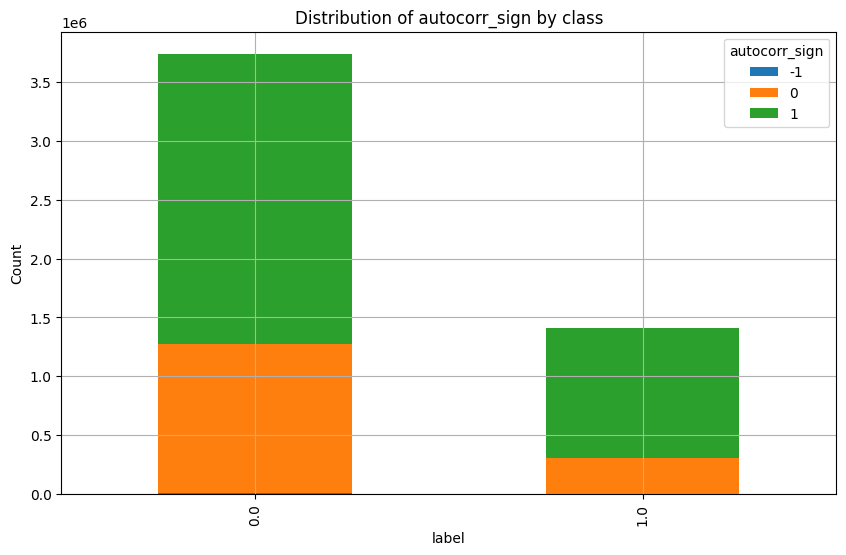

In [27]:
class_autocorr_counts = train_stat_corr.groupby(['label', 'autocorr_sign']).size().unstack()

class_autocorr_counts.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Distribution of autocorr_sign by class')
plt.xlabel('label')
plt.ylabel('Count')
plt.legend(title='autocorr_sign', loc='upper right')
plt.grid(True)
plt.show()


In [11]:
train_stat_corr['autocorr_sign'] = train_stat_corr['autocorr_sign'].replace(-1, 0)

### 3. Frequency-Domain Features

In [14]:
# def extract_features(data):
#     features = {}
#     time_series = data['values'].values
    
#     fft_values = np.fft.rfft(time_series)
#     amplitude = np.abs(fft_values) // 2  
#     features['mean_amplitude'] = np.mean(amplitude)
    
#     try:
#         decomposition = seasonal_decompose(time_series, model='additive', period=12)  
#         trend = decomposition.trend
#         seasonal = decomposition.seasonal

#         features['trend_present'] = int(np.any(np.isnan(trend) == False) and np.nanstd(trend) > 0)

#         features['seasonality_present'] = int(np.any(np.isnan(seasonal) == False) and np.nanstd(seasonal) > 0)
    
#     except Exception as e:
#         features['trend_present'] = 0
#         features['seasonality_present'] = 0
    
#     return features

# def add_features_to_dataframe(data):
#     features = extract_features(data)
    
#     data['mean_amplitude'] = features['mean_amplitude']
#     data['trend_present'] = features['trend_present']
#     data['seasonality_present'] = features['seasonality_present']
    
#     return data

In [15]:
# train_stat_corr_furier = add_features_to_dataframe(train_stat_corr)

In [16]:
# train_stat_corr_furier.head()

,id,dates,values,label,mean_value,std_value,min_value,max_value,median_value,q1_value,q3_value,skewness_value,kurtosis_value,autocorr_sign,mean_amplitude,trend_present,seasonality_present
0,19114,2016-01-01,-1.86,0.0,0.02371,1.348189,-4.84,3.49,-0.11,-0.6825,0.77,-0.304166,1.889654,0,NaN,0,0
1,19114,2016-02-01,0.79,0.0,0.02371,1.348189,-4.84,3.49,-0.11,-0.6825,0.77,-0.304166,1.889654,0,NaN,0,0
2,19114,2016-03-01,1.40,0.0,0.02371,1.348189,-4.84,3.49,-0.11,-0.6825,0.77,-0.304166,1.889654,0,NaN,0,0
3,19114,2016-04-01,0.15,0.0,0.02371,1.348189,-4.84,3.49,-0.11,-0.6825,0.77,-0.304166,1.889654,0,NaN,0,0
4,19114,2016-05-01,0.00,0.0,0.02371,1.348189,-4.84,3.49,-0.11,-0.6825,0.77,-0.304166,1.889654,0,NaN,0,0


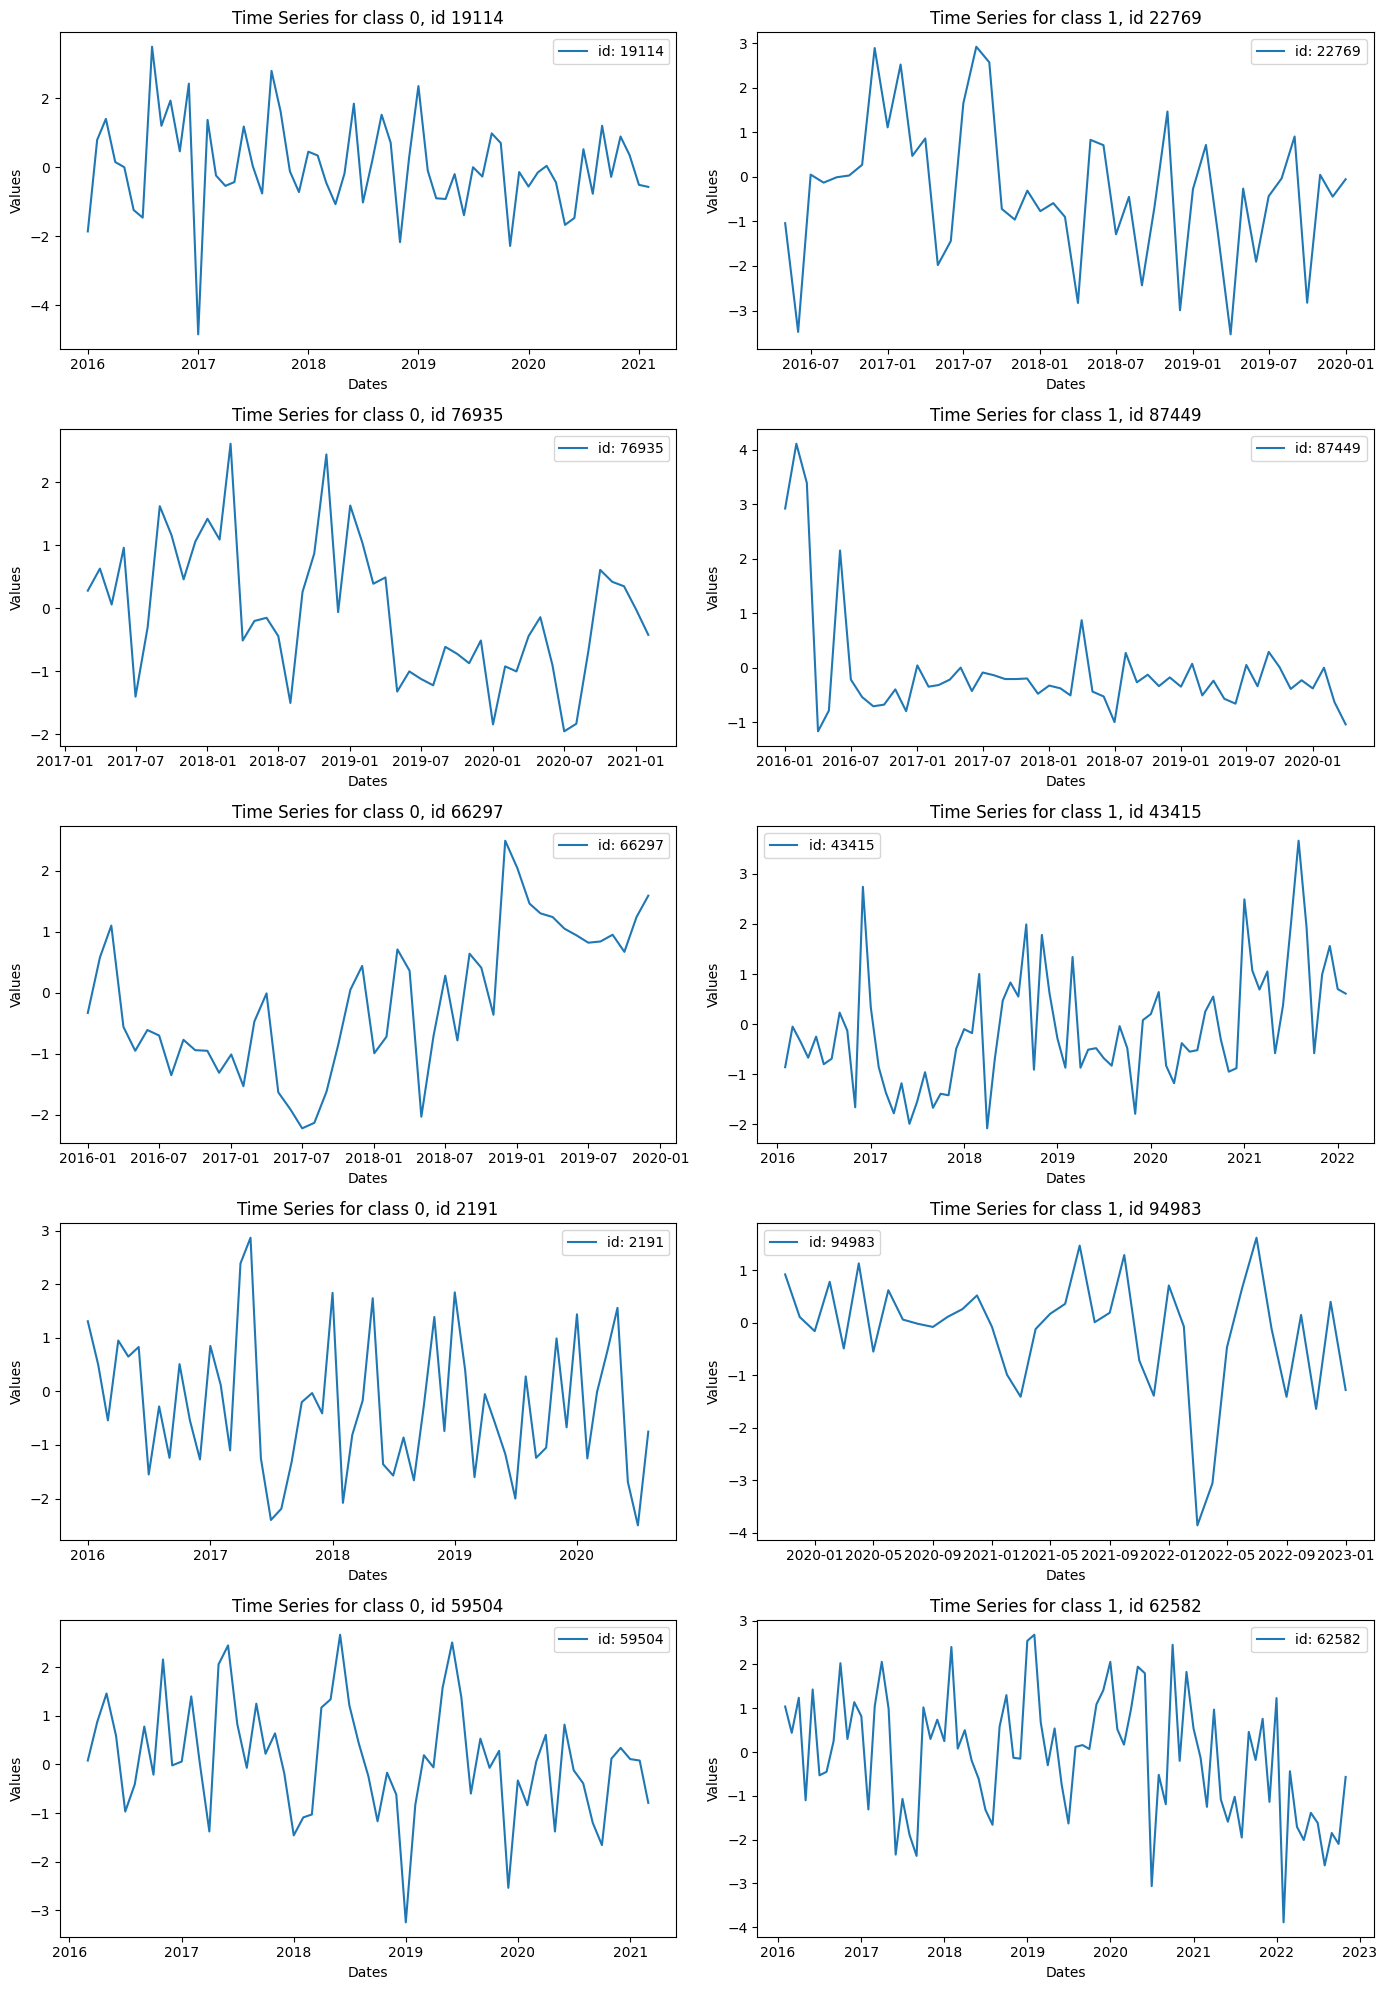

In [51]:
# class_1_ids = train_stat_corr[train_stat_corr['label'] == 1]['id'].unique()[:5]  
# class_0_ids = train_stat_corr[train_stat_corr['label'] == 0]['id'].unique()[:5]  

# def plot_time_series_for_ids(ids, class_label, ax):
#     for i in ids:
#         subset = train_stat_corr[train_stat_corr['id'] == i]
#         ax.plot(subset['dates'], subset['values'], label=f'id: {i}')
    
#     ax.set_title(f'Time Series for class {class_label}')
#     ax.set_xlabel('Dates')
#     ax.set_ylabel('Values')
#     ax.legend()

# fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# # График для класса 1
# plot_time_series_for_ids(class_1_ids, class_label=1, ax=axs[0])

# # График для класса 0
# plot_time_series_for_ids(class_0_ids, class_label=0, ax=axs[1])

# plt.tight_layout()
# plt.show()

class_1_ids = train_stat_corr[train_stat_corr['label'] == 1]['id'].unique()[:5]  
class_0_ids = train_stat_corr[train_stat_corr['label'] == 0]['id'].unique()[:5]

def plot_time_series_for_ids(ids, class_label, ax):
    for i in ids:
        subset = train_stat_corr[train_stat_corr['id'] == i]
        ax.plot(subset['dates'], subset['values'], label=f'id: {i}')
    
    ax.set_title(f'Time Series for class {class_label}')
    ax.set_xlabel('Dates')
    ax.set_ylabel('Values')
    ax.legend()

fig, axs = plt.subplots(5, 2, figsize=(14, 20))

for i, ax in enumerate(axs[:, 0]):
    subset = train_stat_corr[train_stat_corr['id'] == class_0_ids[i]]
    ax.plot(subset['dates'], subset['values'], label=f'id: {class_0_ids[i]}')
    ax.set_title(f'Time Series for class 0, id {class_0_ids[i]}')
    ax.set_xlabel('Dates')
    ax.set_ylabel('Values')
    ax.legend()

for i, ax in enumerate(axs[:, 1]):
    subset = train_stat_corr[train_stat_corr['id'] == class_1_ids[i]]
    ax.plot(subset['dates'], subset['values'], label=f'id: {class_1_ids[i]}')
    ax.set_title(f'Time Series for class 1, id {class_1_ids[i]}')
    ax.set_xlabel('Dates')
    ax.set_ylabel('Values')
    ax.legend()

plt.tight_layout()
plt.show()


### Distribution of features

In [47]:
selected_features = ['mean_value', 'std_value',	'min_value', 'max_value', 'median_value', 'q1_value', 'q3_value', 'skewness_value', 'kurtosis_value', 'autocorr_sign']

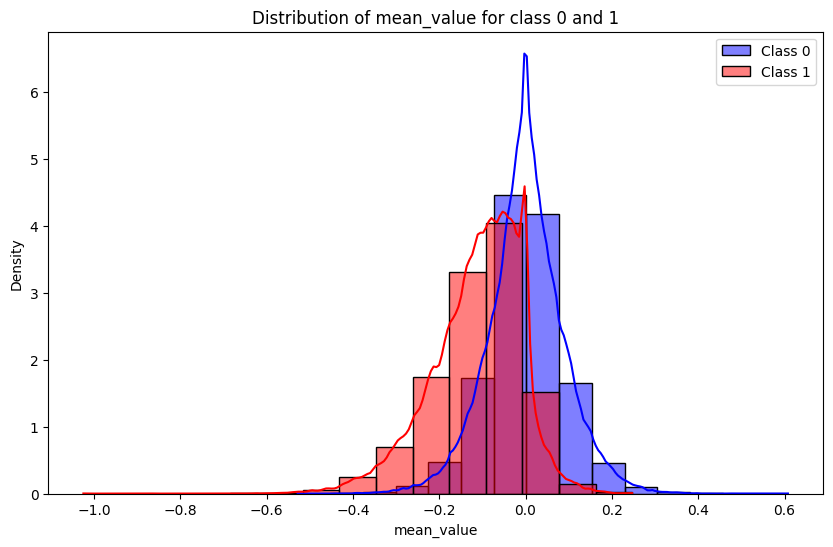

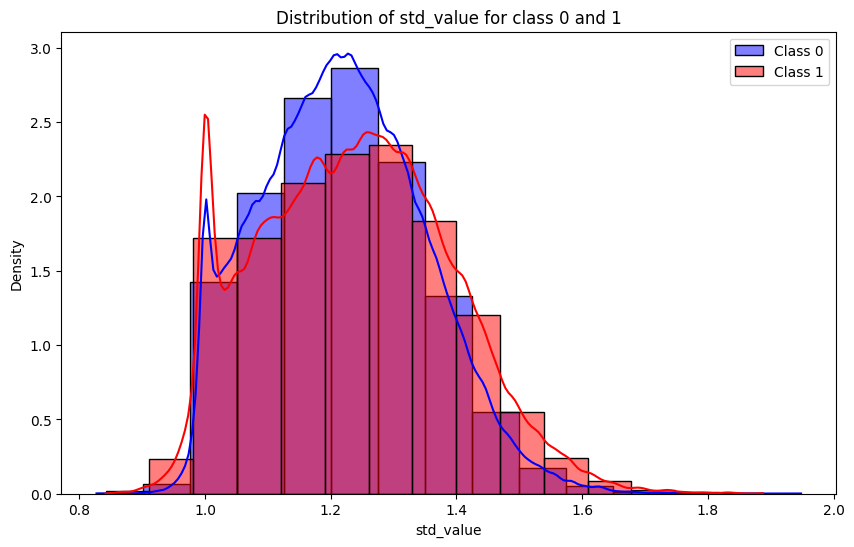

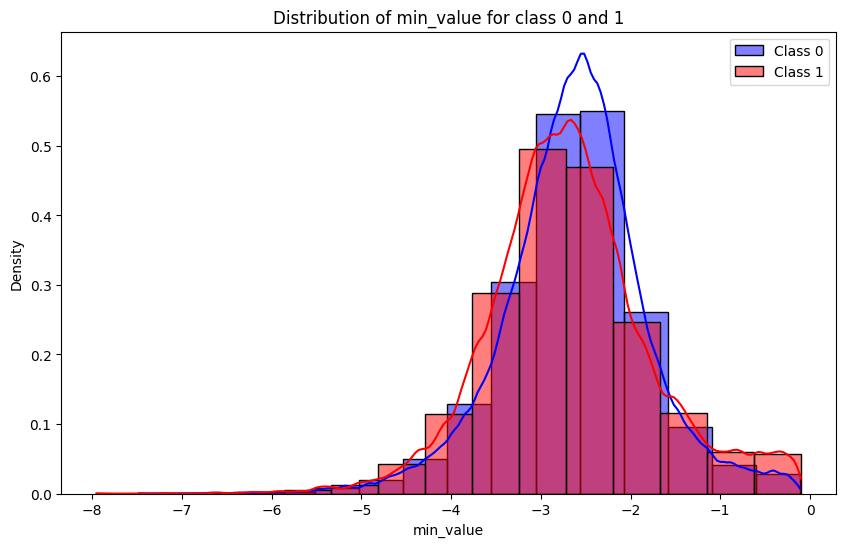

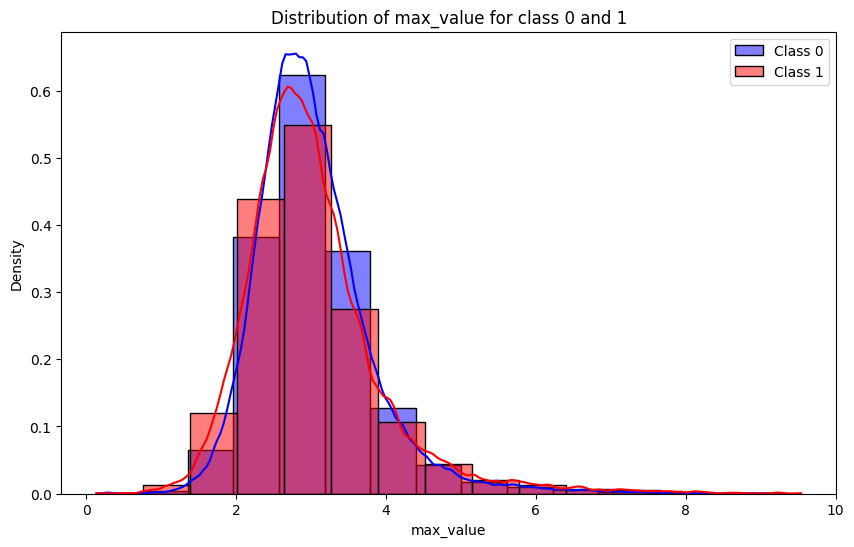

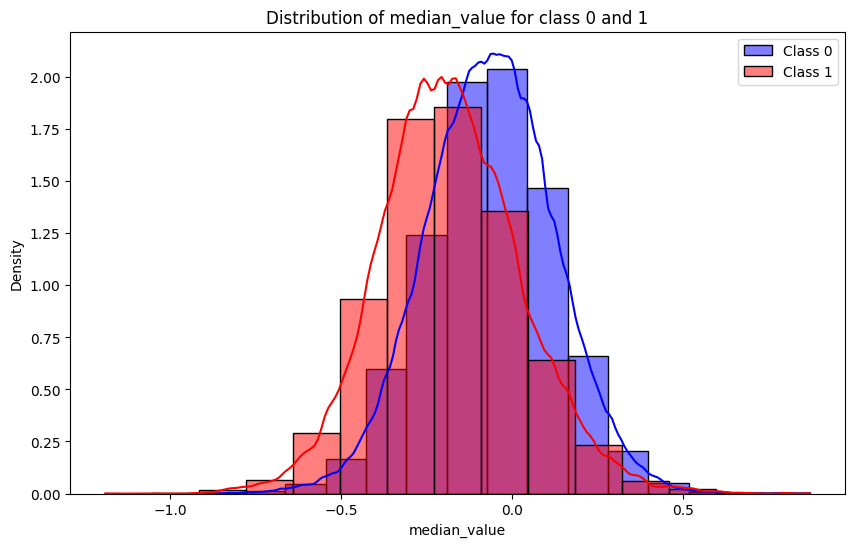

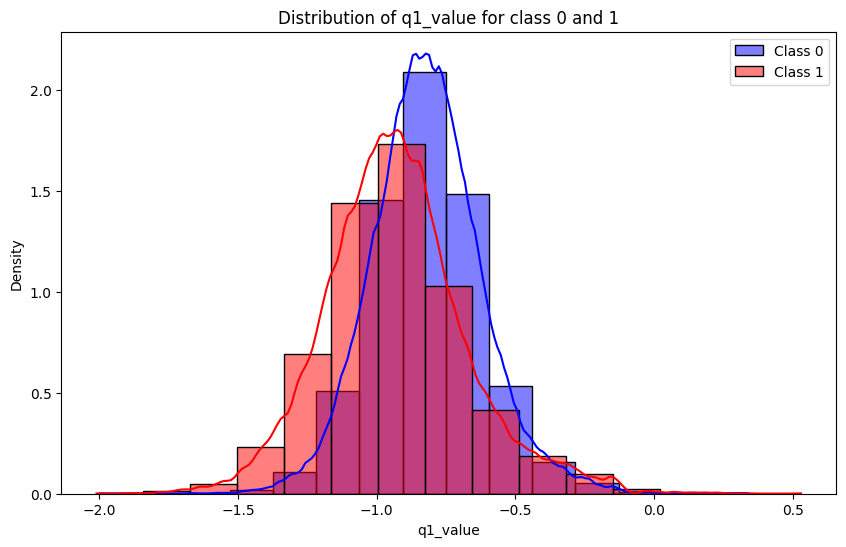

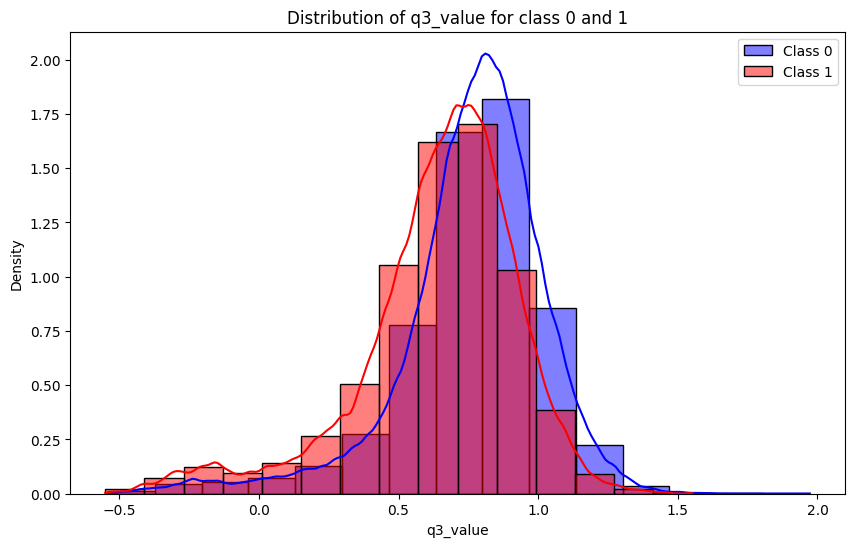

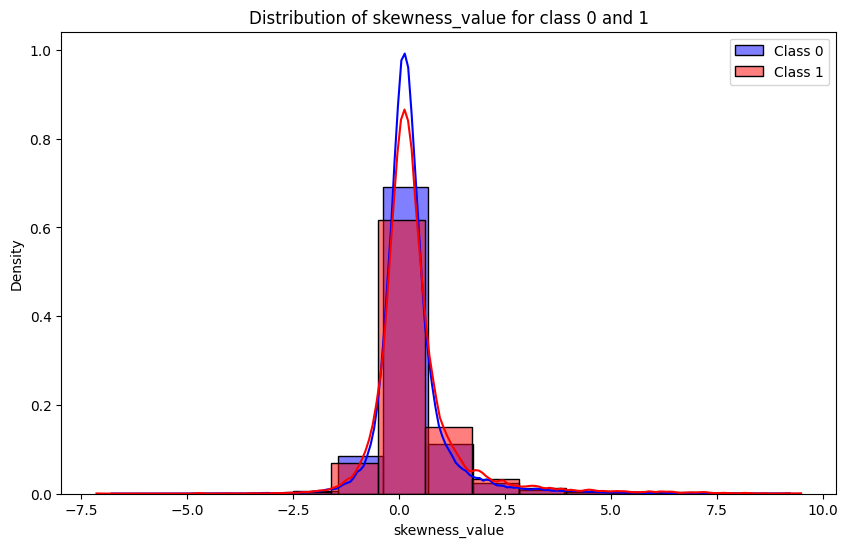

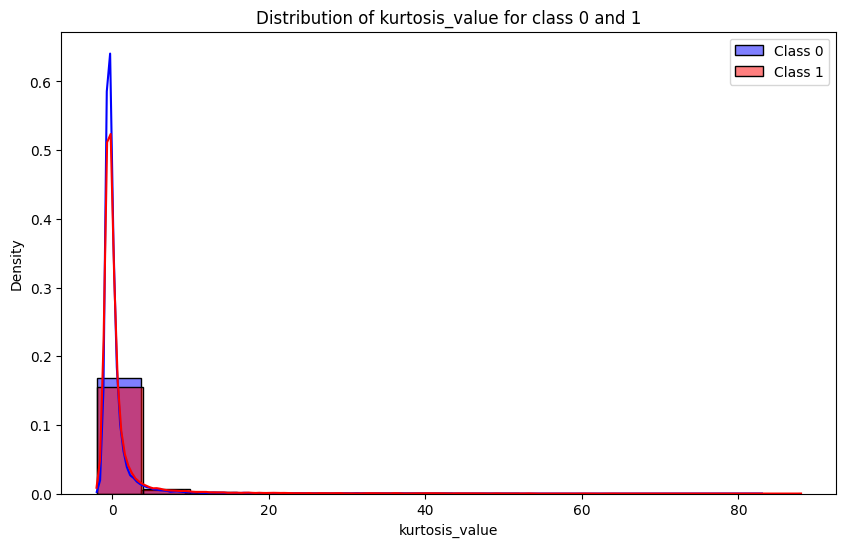

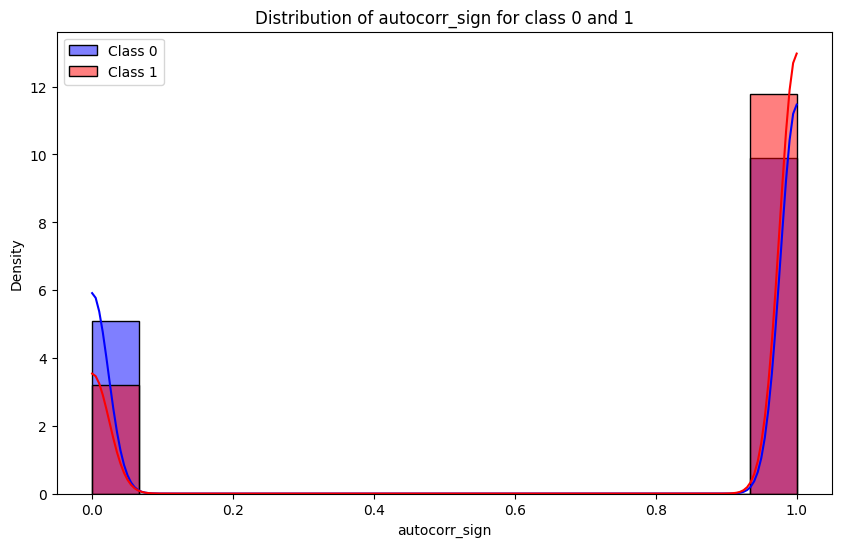

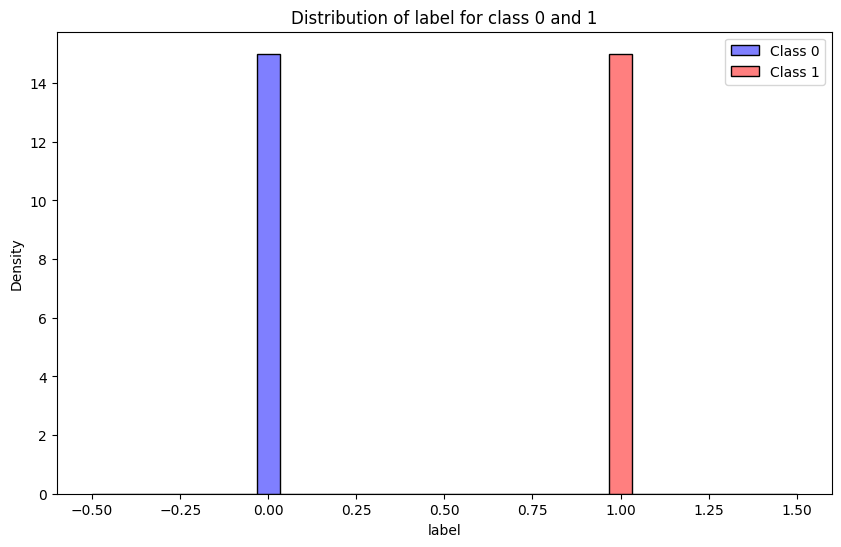

In [26]:
class_0 = train_stat_corr[train_stat_corr['label'] == 0.0]
class_1 = train_stat_corr[train_stat_corr['label'] == 1.0]

for feature in selected_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(class_0[feature], color='blue', label='Class 0', kde=True, stat='density', bins=15)
    sns.histplot(class_1[feature], color='red', label='Class 1', kde=True, stat='density', bins=15)
    plt.title(f"Distribution of {feature} for class 0 and 1")
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

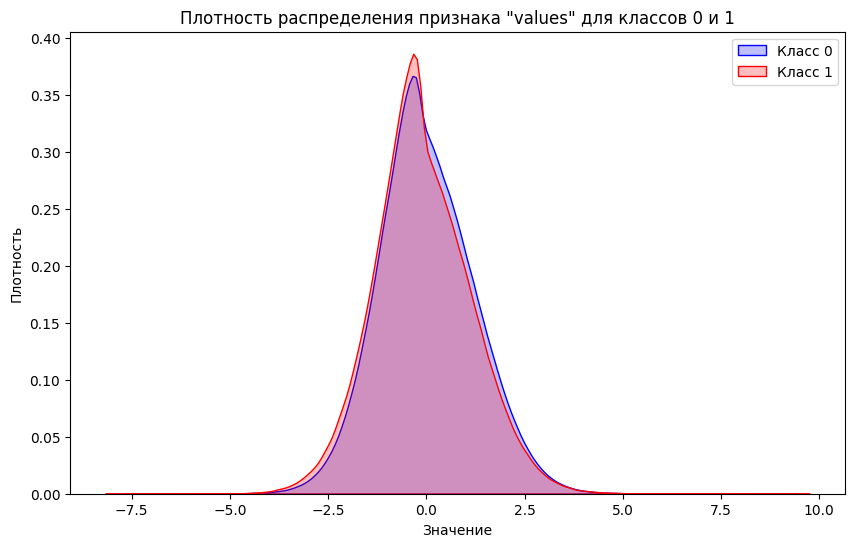

In [29]:
plt.figure(figsize=(10, 6))
sns.kdeplot(train_stat_corr[train_stat_corr['label'] == 0.0]['values'], color='blue', label='Класс 0', fill=True)
sns.kdeplot(train_stat_corr[train_stat_corr['label'] == 1.0]['values'], color='red', label='Класс 1', fill=True)
plt.title('Плотность распределения признака "values" для классов 0 и 1')
plt.xlabel('Значение')
plt.ylabel('Плотность')
plt.legend()
plt.show()


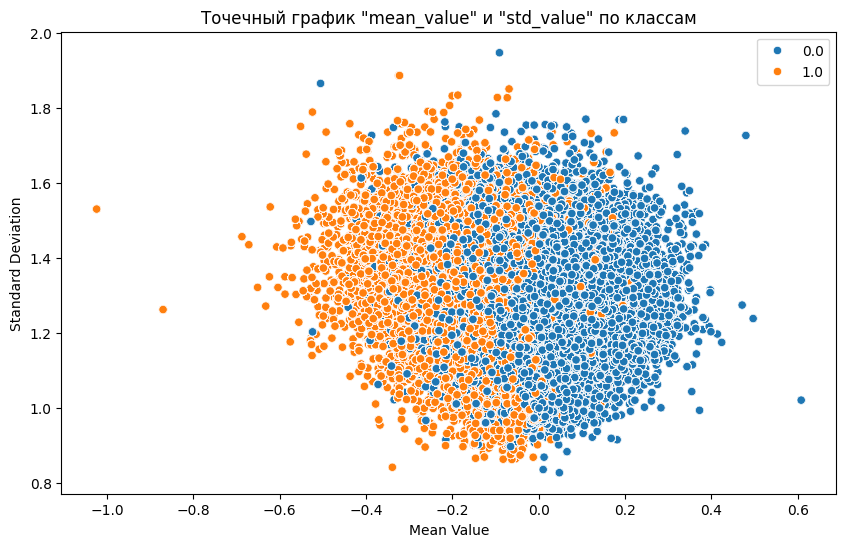

In [33]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='mean_value', y='std_value', hue='label', data=train_stat_corr)
plt.title('Точечный график "mean_value" и "std_value" по классам')
plt.xlabel('Mean Value')
plt.ylabel('Standard Deviation')
plt.legend(loc='upper right')
plt.show()

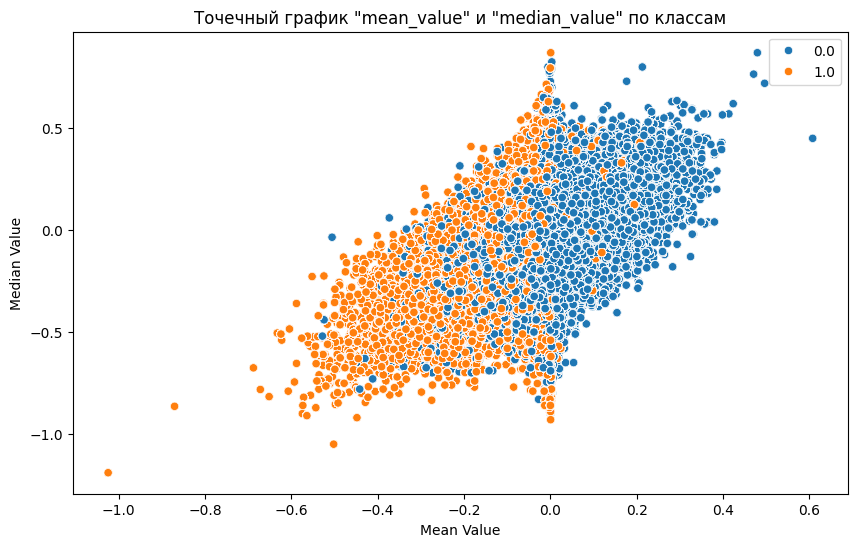

In [46]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='mean_value', y='median_value', hue='label', data=train_stat_corr)
plt.title('Точечный график "mean_value" и "median_value" по классам')
plt.xlabel('Mean Value')
plt.ylabel('Median Value')
plt.legend(loc='upper right')
plt.show()

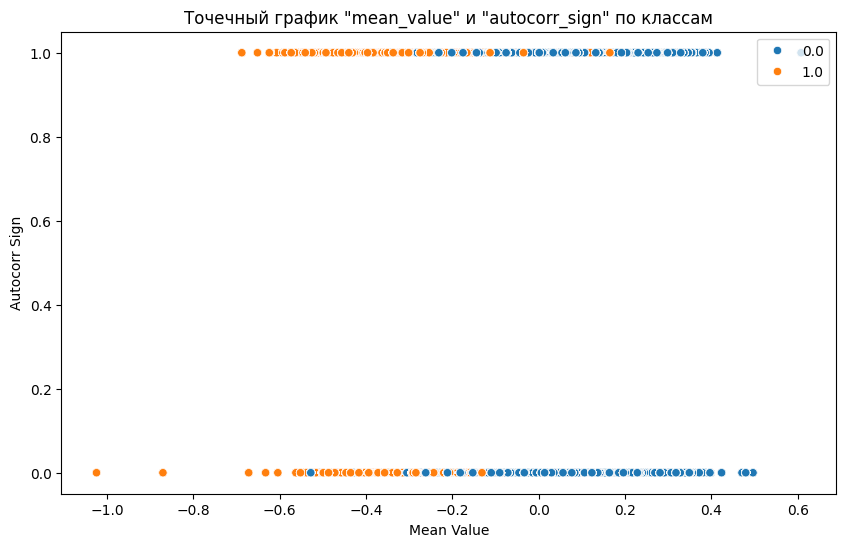

In [49]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='mean_value', y='autocorr_sign', hue='label', data=train_stat_corr)
plt.title('Точечный график "mean_value" и "autocorr_sign" по классам')
plt.xlabel('Mean Value')
plt.ylabel('Autocorr Sign')
plt.legend(loc='upper right')
plt.show()

### Correlation matrix

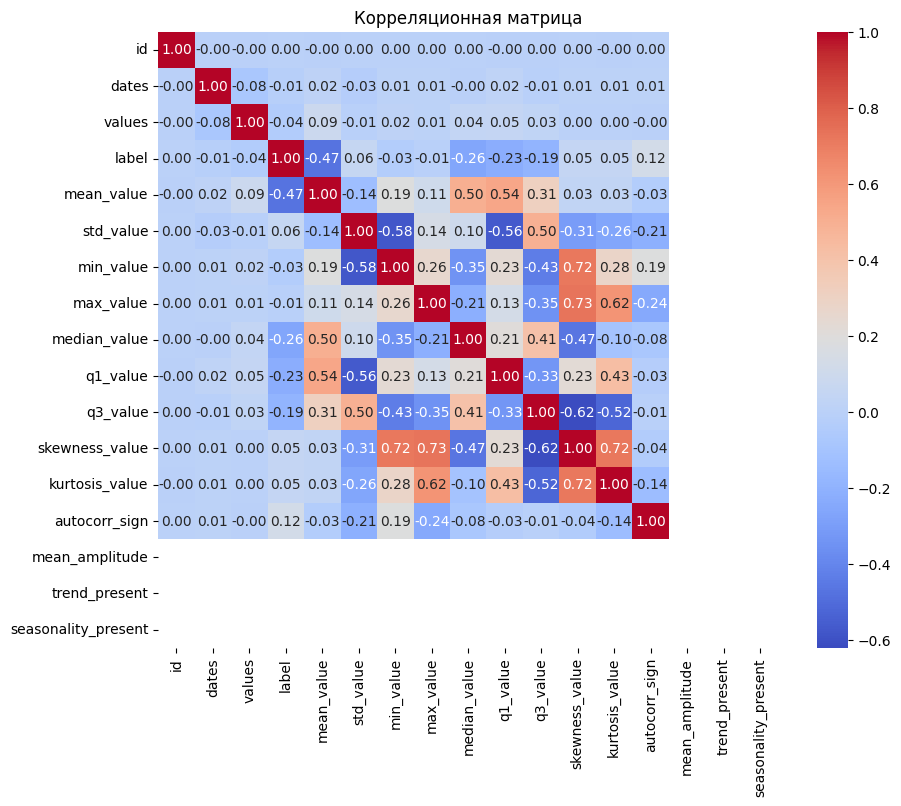

In [30]:
correlation_matrix = train_stat_corr.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

In [43]:
train_df = train_stat_corr.drop(['dates', 'values', 'mean_amplitude', 'trend_present', 'seasonality_present'], axis=1)

##### Delete features with hight correlation

In [44]:
threshold = 0.6

high_corr_pairs = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            high_corr_pairs.add((colname, correlation_matrix.columns[j]))

print("features with hight correlation:")
for pair in high_corr_pairs:
    print(pair)

features with hight correlation:
('skewness_value', 'min_value')
('kurtosis_value', 'skewness_value')
('skewness_value', 'q3_value')
('kurtosis_value', 'max_value')
('skewness_value', 'max_value')


In [45]:
to_remove = set()

for pair in high_corr_pairs:
    to_remove.add(pair[1])

reduced_data = train_df.drop(columns=to_remove)
print("Other features:")
print(reduced_data)

Other features:
            id  label  mean_value  std_value  median_value  q1_value  \
0        19114    0.0    0.023710   1.348189      -0.11000 -0.682500   
1        19114    0.0    0.023710   1.348189      -0.11000 -0.682500   
2        19114    0.0    0.023710   1.348189      -0.11000 -0.682500   
3        19114    0.0    0.023710   1.348189      -0.11000 -0.682500   
4        19114    0.0    0.023710   1.348189      -0.11000 -0.682500   
...        ...    ...         ...        ...           ...       ...   
5155407  98870    1.0   -0.274635   1.421668       0.00335 -1.113325   
5155408  98870    1.0   -0.274635   1.421668       0.00335 -1.113325   
5155409  98870    1.0   -0.274635   1.421668       0.00335 -1.113325   
5155410  98870    1.0   -0.274635   1.421668       0.00335 -1.113325   
5155411  98870    1.0   -0.274635   1.421668       0.00335 -1.113325   

         kurtosis_value  autocorr_sign  
0              1.889654              0  
1              1.889654              

### Train model

In [ ]:
from sklearn.model_selection import train_test_split as split
from sklearn.preprocessing import StandardScaler

X = reduced_data.drop('target', axis=1)
y = reduced_data['target']

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)
scaled_data_df = pd.DataFrame(scaled_data, columns=X.columns)

X_train, X_test, y_train, y_test = split(scaled_data_df, y, test_size=0.3)